In [9]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask.any() != None:
        print("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
#     print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [11]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [12]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

In [13]:
dfhw=pd.read_csv("01_heights_weights_genders.csv")
print(dfhw.shape)
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [14]:

df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

263

In [15]:
df.shape[0]

500

In [16]:
itrain, itest = train_test_split(np.arange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([False, False,  True,  True,  True, False, False,  True,  True,
        True])

using mask


c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\akshitha\appdata\local\prog

BEST {'C': 0.1} 0.91 {'mean_fit_time': array([0.04160237, 0.00079989, 0.00079856, 0.        , 0.        ,
       0.00080214, 0.00089507, 0.        ]), 'std_fit_time': array([0.07268054, 0.00159979, 0.00159712, 0.        , 0.        ,
       0.00160427, 0.00179014, 0.        ]), 'mean_score_time': array([0.        , 0.0007988 , 0.00079885, 0.00080404, 0.00079188,
       0.        , 0.00080056, 0.        ]), 'std_score_time': array([0.        , 0.0015976 , 0.00159769, 0.00160809, 0.00158377,
       0.        , 0.00160112, 0.        ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.90163934, 0.91803279, 0.91803279, 0.91803279, 0.91803279,
       0.91803279, 0.91803279, 0.91803279]), 'split1_test_sco

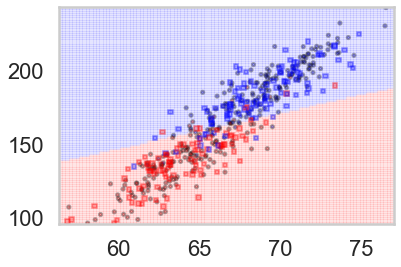

In [17]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [18]:
clflog.predict(Xtest)

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0])

In [19]:
clflog.predict_proba(Xtest)

array([[1.35642100e-02, 9.86435790e-01],
       [4.74837400e-03, 9.95251626e-01],
       [2.32306520e-01, 7.67693480e-01],
       [9.99686875e-01, 3.13124871e-04],
       [9.99539641e-01, 4.60359429e-04],
       [1.78666589e-03, 9.98213334e-01],
       [2.85093046e-02, 9.71490695e-01],
       [1.58518579e-03, 9.98414814e-01],
       [9.39160271e-01, 6.08397288e-02],
       [8.35367999e-02, 9.16463200e-01],
       [4.45896000e-02, 9.55410400e-01],
       [9.16696978e-01, 8.33030217e-02],
       [8.83733131e-01, 1.16266869e-01],
       [9.33173481e-01, 6.68265191e-02],
       [4.25737815e-02, 9.57426218e-01],
       [9.67129414e-01, 3.28705859e-02],
       [2.02356878e-02, 9.79764312e-01],
       [8.37628695e-01, 1.62371305e-01],
       [5.25524249e-03, 9.94744758e-01],
       [9.70639924e-01, 2.93600763e-02],
       [9.98975726e-01, 1.02427392e-03],
       [1.07793358e-01, 8.92206642e-01],
       [1.04126111e-01, 8.95873889e-01],
       [2.07798796e-02, 9.79220120e-01],
       [9.925669

In [20]:
clflog.predict_proba(Xtest)[:,1]

array([9.86435790e-01, 9.95251626e-01, 7.67693480e-01, 3.13124871e-04,
       4.60359429e-04, 9.98213334e-01, 9.71490695e-01, 9.98414814e-01,
       6.08397288e-02, 9.16463200e-01, 9.55410400e-01, 8.33030217e-02,
       1.16266869e-01, 6.68265191e-02, 9.57426218e-01, 3.28705859e-02,
       9.79764312e-01, 1.62371305e-01, 9.94744758e-01, 2.93600763e-02,
       1.02427392e-03, 8.92206642e-01, 8.95873889e-01, 9.79220120e-01,
       7.43303223e-03, 8.67199284e-01, 9.91815594e-01, 2.20067537e-01,
       9.28991559e-02, 1.31371454e-02, 7.48722309e-02, 3.83682029e-01,
       2.28448426e-02, 9.90666621e-01, 9.27279810e-01, 9.99502852e-01,
       1.05731631e-03, 1.18178785e-02, 3.64798733e-01, 2.99304427e-01,
       9.05324845e-01, 9.51214739e-01, 6.36439318e-03, 7.93293826e-01,
       8.36798803e-02, 5.04303553e-03, 2.21903759e-04, 9.96512983e-01,
       3.30636786e-02, 9.10686609e-01, 9.66772495e-01, 7.15375913e-01,
       8.30087756e-01, 5.20043995e-04, 9.73104933e-02, 8.09022541e-01,
      

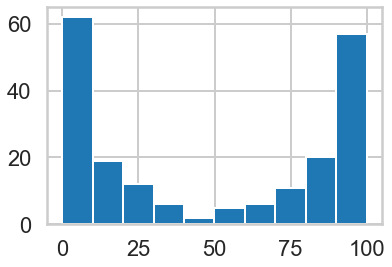

In [21]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

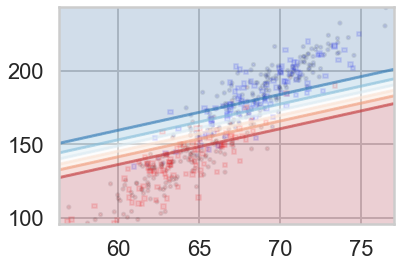

In [23]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In [24]:
clflog.score(Xtest, ytest)

0.895

using mask
BEST {'C': 0.001} 0.9133333333333333 {'mean_fit_time': array([0.00100965, 0.00165401, 0.00154257, 0.01213894, 0.07191954,
       0.33578892, 0.67412639]), 'std_fit_time': array([0.00156913, 0.00170265, 0.00157533, 0.00846734, 0.03129687,
       0.097196  , 0.20179468]), 'mean_score_time': array([0.00020657, 0.00020623, 0.00065036, 0.00084829, 0.        ,
       0.00055552, 0.00083165]), 'std_score_time': array([0.00041313, 0.00041246, 0.00130072, 0.00169659, 0.        ,
       0.0007151 , 0.0016633 ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.91803279, 0.90163934, 0.90163934, 0.90163934, 0.90163934,
       0.90163934, 0.8852459 ]), 'split1_test_score': array([0.86666667, 0.85      , 0.85      , 0.85      , 0

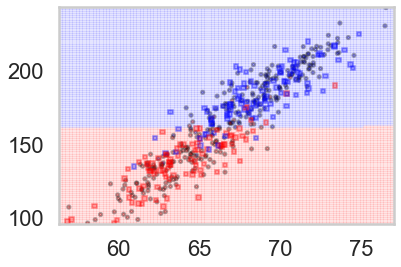

In [25]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

In [26]:

clfsvm.decision_function(Xtest)

array([ 2.81270601,  3.20803503,  0.50305308, -4.80491403, -4.09862386,
        4.25480027,  2.54055276,  4.30810001, -1.76942212,  1.26186546,
        1.9431242 , -1.87241326, -1.15601392, -1.34774718,  2.12209449,
       -2.2389805 ,  2.09775317, -0.43601791,  3.12848799, -2.2193283 ,
       -3.97979068,  0.87233627,  1.79928719,  3.3091557 , -3.22158968,
        1.29062823,  2.94017469, -0.83618039, -1.8155562 , -2.44801278,
       -1.86257731, -0.33404591, -1.93071495,  2.87850717,  1.04079185,
        4.53295707, -4.77130183, -2.2618212 , -0.26257152, -0.25737541,
        1.03608999,  0.8428475 , -3.16898885,  1.24898391, -1.60536085,
       -3.0731525 , -4.99630025,  4.06207934, -2.08258112,  1.8134023 ,
        3.12020955,  0.80793611,  1.24146479, -3.6395679 , -1.4401349 ,
        0.79741883,  2.05066799,  2.42478093, -1.94213755,  1.36680403,
        1.04912516,  0.20980443,  0.57228944,  1.08919978, -1.24834572,
       -3.02426086, -2.01087793,  1.90632215, -2.24993834,  1.13

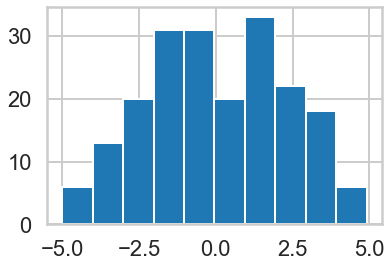

In [27]:
plt.hist(clfsvm.decision_function(Xtest));

c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
c:\users\akshitha\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


TypeError: clabel() got an unexpected keyword argument 'axes'

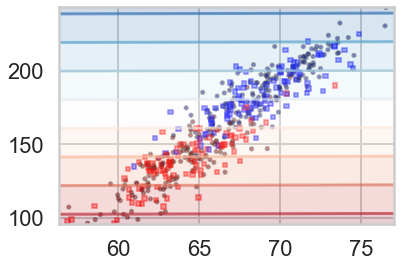

In [28]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

In [29]:
def plot_svc_decision_function(clf, ax=None):
    
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[56.35608213 95.43328554].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

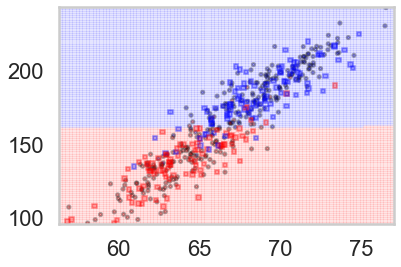

In [30]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

In [31]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[88,  8],
       [13, 91]], dtype=int64)

In [32]:
from sklearn.metrics import classification_report
print (classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89        96
           1       0.92      0.88      0.90       104

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.90       200



In [33]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [34]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[ 60,  36],
       [  2, 102]], dtype=int64)

In [35]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

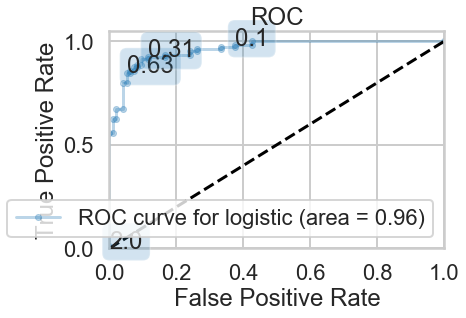

In [36]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

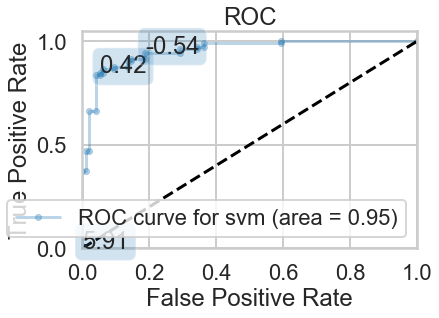

In [37]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)